In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%load_ext autoreload
%autoreload 2
import os
UAH_DATA_PATH = 'drive/MyDrive/UAH - Aprendizaje profundo/data'
os.listdir(UAH_DATA_PATH)

['sonetos_Shakespeare.txt',
 'shakespeare.txt',
 'drugsComTrain_raw.tsv',
 'drugsComTest_raw.tsv',
 'drugLibTest_raw.tsv',
 'drugLibTrain_raw.tsv',
 'creditcard.csv',
 'drugsCom_raw.zip']

In [ ]:
os.path.isfile(os.path.join('data', 'drugsCom_raw.tsv'))

False

In [ ]:
# !pip install pandas spacy sklearn lightgbm

In [ ]:
from tensorflow.python.client import device_lib

def gpuon():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos if x.device_type == 'GPU'])

gpuon()

['/device:GPU:0']


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score

pd.options.display.max_colwidth = 500

In [ ]:
df_train = pd.read_csv(os.path.join(UAH_DATA_PATH, 'drugsComTrain_raw.tsv'),
                       sep='\t',
                       quotechar = '"',
                       encoding='latin-1',
                       index_col=0)
df_test = pd.read_csv(os.path.join(UAH_DATA_PATH, 'drugsComTest_raw.tsv'),
                      sep='\t',
                      quotechar = '"',
                      encoding='latin-1',
                      index_col=0)
df = pd.concat([df_train, df_test])
df.columns = df.columns.str.replace('(.)([A-Z][a-z]+)', r'\1_\2', regex=True).str.lower()
df.review = df.review.str.slice(1, -1).str.strip()
df.shape

(215063, 6)

In [ ]:
df.head()

,drug_name,condition,review,rating,date,useful_count
206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil",9.0,"May 20, 2012",27
95260,Guanfacine,ADHD,"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. H...",8.0,"April 27, 2010",192
92703,Lybrel,Birth Control,"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things g...",5.0,"December 14, 2009",17
138000,Ortho Evra,Birth Control,"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch",8.0,"November 3, 2015",10
35696,Buprenorphine / naloxone,Opiate Dependence,"Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again. I ha...",9.0,"November 27, 2016",37


In [ ]:
df.drug_name.nunique(), df.condition.nunique()

(3671, 916)

In [ ]:
df.drug_name.value_counts().gt(60).sum()

601

In [ ]:
df.condition.value_counts().gt(60).sum()

240

In [ ]:
CONDITION_AMOUNT_THRESHOLD = 100

valid_condictions = df.condition.value_counts()
# valid_condictions = valid_condictions[valid_condictions.str.contains('span')]
valid_condictions = valid_condictions[valid_condictions > CONDITION_AMOUNT_THRESHOLD].index
valid_condictions = valid_condictions[~valid_condictions.str.contains('span|moterol')]
valid_condictions.size

182

In [ ]:
N_FIRST_ONES = 30
valid_condictions[-N_FIRST_ONES:]

Index(['Alopecia', 'Renal Cell Carcinoma', 'Neuralgia', 'Vertig',
       'Dietary Supplementation', 'Angina', 'Hirsutism', 'Autism',
       'Supraventricular Tachycardia', 'Muscle Pain', 'Hemorrhoids',
       'Amenorrhea', 'Obstructive Sleep Apnea/Hypopnea Syndrome',
       'Benign Essential Trem', 'Alzheimer's Disease',
       'Chronic Fatigue Syndrome', 'Rhinitis', 'Heart Failure',
       'Chronic Myelogenous Leukemia', 'Allergic Reactions', 'Prostatitis',
       'Postpartum Depression', 'Postherpetic Neuralgia', 'Dental Abscess',
       'Premature Lab', 'Anorexia', 'Deep Vein Thrombosis', 'Sinus Symptoms',
       'Binge Eating Disorde', 'Dysuria'],
      dtype='object')

In [ ]:
df.shape

(215063, 6)

In [ ]:
df = df.loc[df.condition.isin(valid_condictions[-N_FIRST_ONES:])]

In [ ]:
df.shape

(3490, 6)

In [ ]:
df.review.head(2)

119705                         I have been on Tasigna for just over 3 years now (300mg x 2 times a day) Tasigna worked for me within a few weeks I have been in remission for basically the entire 3 years. As for the side effects, I feel sick to my stomach, tired,  severe leg and arm pain, I can&#039;t walk to long without needing a break, I went from working full time to not working at all because I am so tired all the time.... but hey I am in remission and alive so is all the above really a problem? Nope
206180    I&#039;m writing a second review on Vaniqa.  I started using this in February this year. Twice a day although some days/times I do forget. I just want to say how delighted I am to have found this. It has totally and completely changed my life! I had terrible male pattern hair growth all over my cheeks, chin, upper and lower lip and starting to grow down my neck. I used to pluck for up to 2 hrs a time every 3rd day but was never hair free. I wouldn&#039;t kiss anyone hello or 

In [ ]:
# !pip install spacy

In [ ]:
# !python -m spacy download en_core_web_md

python -m spacy download en_core_web_md

import spacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md", exclude=['ner'])
nlp.component_names

['tok2vec', 'tagger', 'parser', 'senter', 'attribute_ruler', 'lemmatizer']

In [ ]:
doc = nlp("My name is Obama, I killed so many people in Irak. My friends do like whisky")

In [ ]:
doc

My name is Obama, I killed so many people in Irak. My friends do like whisky

In [ ]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.has_vector)

My my PRON True
name name NOUN True
is be AUX True
Obama Obama PROPN True
, , PUNCT True
I I PRON True
killed kill VERB True
so so ADV True
many many ADJ True
people people NOUN True
in in ADP True
Irak Irak PROPN True
. . PUNCT True
My my PRON True
friends friend NOUN True
do do VERB True
like like ADP True
whisky whisky NOUN True


In [ ]:
token.vector[:3]

array([-0.82183, -0.58732,  0.77455], dtype=float32)

In [ ]:
for sent in doc.sents:
    print(sent.text)

My name is Obama, I killed so many people in Irak.
My friends do like whisky


In [ ]:
def crive_text(text, nlp_model, lemmatise=False):
    doc = nlp_model(text)

    final_tokens = []
    for token in doc:
        if token.pos_ in ['NOUN', 'VERB']:
            if lemmatise:
                value_to_append = token.lemma_
            else:
                value_to_append = token.text
            final_tokens.append(value_to_append)

    return final_tokens

In [ ]:
crive_text("My name is Obama, I killed so many people in Irak. My friends do like whisky", nlp, lemmatise=True)

['name', 'kill', 'people', 'friend', 'do', 'whisky']

In [ ]:
np.zeros(14)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator


class SpacySumEmbedder(TransformerMixin, BaseEstimator):

    def __init__(self, valid_pos={'NOUN', 'VERB', 'ADJ', 'ADVERB'}):
        self.valid_pos = valid_pos
        self.null_vector = np.zeros(300)

    def transform(self, X):
        arr_list = []

        for i in range(len(X)):
            doc = X[i]

            vector_list = []

            for token in doc:
                if token.has_vector and (token.pos_ in self.valid_pos):
                    vector_list.append(token.vector)
            if len(vector_list) == 0:
                representation_arr = self.null_vector
            else:
                vector_arr = np.vstack(vector_list)
                representation_arr = np.mean(vector_arr, axis=0)

            arr_list.append(representation_arr)

        X_transformed = np.vstack(arr_list)

        return X_transformed

In [ ]:
df.head(
)

,drug_name,condition,review,rating,date,useful_count
119705,Nilotinib,Chronic Myelogenous Leukemia,"I have been on Tasigna for just over 3 years now (300mg x 2 times a day) Tasigna worked for me within a few weeks I have been in remission for basically the entire 3 years. As for the side effects, I feel sick to my stomach, tired, severe leg and arm pain, I can&#039;t walk to long without needing a break, I went from working full time to not working at all because I am so tired all the time.... but hey I am in remission and alive so is all the above really a problem? Nope",10.0,"September 1, 2015",11
206180,Eflornithine,Hirsutism,"I&#039;m writing a second review on Vaniqa. I started using this in February this year. Twice a day although some days/times I do forget. I just want to say how delighted I am to have found this. It has totally and completely changed my life! I had terrible male pattern hair growth all over my cheeks, chin, upper and lower lip and starting to grow down my neck. I used to pluck for up to 2 hrs a time every 3rd day but was never hair free. I wouldn&#039;t kiss anyone hello or goodbye as even ...",10.0,"May 11, 2014",99
60455,Pyridium,Dysuria,"I&#039;ve been having UTIs for 7 years, my most recent one has lasted 24 days so far. Because of this I went to the doctor and they prescribed me pyridium twice a day. I was very hopeful but unfortunately it didn&#039;t work. The burning while urinating is still there and I&#039;ve been on it for three days so far. Also discomfort all hours of the day down there. It may work well for others but my body doesn&#039;t accept it, it did nothing. Going to the doctor was useless, go straight to th...",1.0,"October 13, 2016",8
154893,Metronidazole,Dental Abscess,"I&#039;ve been taking metronidazoles for 4 days (3 a day) and I&#039;m still in agony, I&#039;ve tried so many painkillers and nothing helps, my right side of my face is in agony and I can&#039;t eat or drink anything hot or too cold, cold air hurts my gums also, anyone have any advice?",5.0,"December 15, 2016",22
102720,Aripiprazole,Autism,"My stepson is now 13 years old and has been on 5mg dosage of Abilify for about 2-3 years. We discovered it when we saw a commercial for a study involving autistic children with aggressive tendencies. Since then, his behavior has improved 100% at both home and school. The only side effect, as mentioned by others, is weight gain. To this I say, take a more active role in your kid&#039;s diet and force him/her to exercise. This will offset the side-effects while still reaping the benefits.",10.0,"February 7, 2014",141


In [ ]:
df.shape

(3490, 6)

In [ ]:
N_EXAMPLES = 3490

text_series = df.review.head(N_EXAMPLES)
target_series = df.condition.head(N_EXAMPLES)
rating_target_series = df.rating.head(N_EXAMPLES)
target_series.value_counts()

Alopecia                                     125
Neuralgia                                    125
Renal Cell Carcinoma                         125
Vertig                                       124
Dietary Supplementation                      124
Angina                                       123
Hirsutism                                    122
Autism                                       121
Supraventricular Tachycardia                 121
Muscle Pain                                  119
Amenorrhea                                   118
Hemorrhoids                                  118
Obstructive Sleep Apnea/Hypopnea Syndrome    117
Benign Essential Trem                        117
Alzheimer's Disease                          117
Chronic Fatigue Syndrome                     116
Allergic Reactions                           115
Chronic Myelogenous Leukemia                 115
Heart Failure                                115
Rhinitis                                     115
Prostatitis         

In [ ]:
doc_list = list(nlp.pipe(text_series))

doc_vectors_arr = np.vstack([doc.vector for doc in doc_list])
doc_vectors_arr.shape

(3490, 300)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg_log', LogisticRegression(class_weight='balanced', max_iter=2000))
])

# log_reg = LogisticRegression(class_weight='balanced', max_iter=2000)
pipe.fit(doc_vectors_arr, target_series)

pipe.predict(doc_vectors_arr[:5, :])

array(['Chronic Myelogenous Leukemia', 'Hirsutism', 'Dysuria',
       'Dental Abscess', 'Autism'], dtype=object)

In [ ]:
from sklearn.linear_model import Ridge


reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg_log', Ridge())
])

reg_pipe.fit(doc_vectors_arr, rating_target_series)

reg_pipe.predict(doc_vectors_arr[:5, :])

array([8.281068 , 8.326783 , 7.1468678, 6.7747746, 8.299815 ],
      dtype=float32)

In [ ]:
rating_target_series.head(5)

119705    10.0
206180    10.0
60455      1.0
154893     5.0
102720    10.0
Name: rating, dtype: float64

In [ ]:
# !pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor

reg = LGBMRegressor()
reg.fit(doc_vectors_arr, rating_target_series)
reg.predict(doc_vectors_arr[:5, :])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3490, number of used features: 300
[LightGBM] [Info] Start training from score 7.302865


array([9.50951724, 9.83433629, 1.45329945, 5.80501002, 9.98615542])

In [ ]:
reg.predict(doc_vectors_arr[:10, :])

array([9.50951724, 9.83433629, 1.45329945, 5.80501002, 9.98615542,
       9.28311525, 9.521365  , 7.71132809, 9.43483294, 9.77342982])

In [ ]:
rating_target_series.iloc[:10]

119705    10.0
206180    10.0
60455      1.0
154893     5.0
102720    10.0
140378    10.0
59556     10.0
65841      8.0
60520     10.0
18475     10.0
Name: rating, dtype: float64

In [ ]:
type(doc_list[0])

spacy.tokens.doc.Doc

In [ ]:
spacy_embedder = SpacySumEmbedder()
rep_arr = spacy_embedder.transform(doc_list)

In [ ]:
rep_arr.shape

(1000, 300)

In [ ]:
df.shape

(3490, 6)

In [ ]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
doc_list = list(nlp.pipe(df.review, n_process=6,
                         disable=['ner']))

In [ ]:
doc_series = pd.Series(doc_list, index=df.review.index)

In [ ]:
doc_len_series = doc_series.map(lambda doc: len(doc))

In [ ]:
doc_len_series

119705    110
206180    160
60455     103
154893     60
102720    110
         ... 
60966      36
44591      25
111790     10
190758    168
92720      54
Length: 3490, dtype: int64

In [ ]:
doc_len_series.quantile(np.linspace(0.5, 1, 11))

0.50     77.00
0.55     84.95
0.60     94.00
0.65    102.00
0.70    112.00
0.75    126.00
0.80    139.00
0.85    149.00
0.90    156.00
0.95    163.00
1.00    199.00
dtype: float64

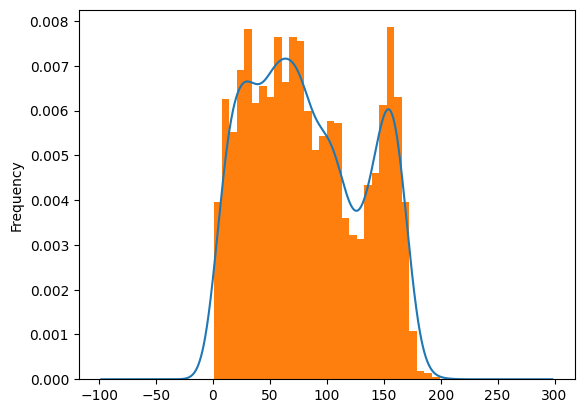

In [ ]:
%matplotlib inline

doc_len_series.plot.kde();
doc_len_series.plot.hist(density=True, bins=30);

In [ ]:
MAX_LEN = 200

In [ ]:
REGEX_PATTERN_LIST = [('\s+', ' '),
                      ('\&\#039;', "\'"),
                      ('&amp', '&')]

In [ ]:
import re

re.sub('\&\#039;', "\'", "I&#039;m Will")

"I'm Will"

In [ ]:
df.review.str.contains('&#039;').mean()

0.49398280802292266

In [ ]:
def preprocess_df(df, regex_pattern_list, target_col='review'):

    pro_df = df.copy()

    for pattern in regex_pattern_list:

        pro_df[target_col] = pro_df[target_col].str.replace(pattern[0], pattern[1], regex=True)
#         pro_df[target_col] = (pro_df[target_col]
#                               .map(lambda s: re.sub(pattern[0], pattern[1], s)))

    return pro_df

pro_df = preprocess_df(df, REGEX_PATTERN_LIST)
pro_df.shape

(3490, 6)

In [ ]:
pro_df.review.sample(5).to_list()

["It did help my tremors quite a bit. I have been on it for 16 years, however, because of extra stress, I am trying something in the same family, Atenolol. Don't know if will help any more than propanolol has helped.",
 'Caused hyperactivity and cause me to gain weight and develop breasts.',
 'Used this for severely underweight toddler (borderline failure to thrive) to gently bring the weight back on to the growth chart. Managed to bring the weight up from off the chart to 25% (for a 90% height baby).',
 "Hair grew back almost instantly. I got Kenalog-10 injections from my doctor in late September. I started noticing hair growth after only a few days. Almost two months later now and my hair is almost completely grown. No more bald spots. It's not perfect, but it's getting there really quick. It was somewhat painful but totally worth it.",
 "I had to fight with insurance to cover my Nuvigil but finally got them too. I have battled to get my hypothyroidism optimized for years and even wh

In [ ]:
pro_df.review.str.contains('\&\#039;').sum()

0

In [ ]:
pro_df.review.sample(2)

36118    I had a virus infection of the back wall of my heart. In Feb 2007, my EF was 20% and I was throwing PVC's like crazy. My cardiologist started me on Coreg (carvedilol) but could not tolerate a dose higher than 3.125mg and he also started me on Vasotec (enalapril) and, again, I could not tolerate a dose higher than 2.5mg. In fact, I take my blood pressure before every dose (2x daily) and if it is less than 130, I do not take the Vasotec. By June 2007, my EF was 68% and only the occasional PVC ...
60912                                                                                                                                                                                                                                                Best medicine to open your ears and sinuses when they are really congested. I have tried everything. The name brand is great but the store brands or generic brands can cause rapid heart rate even though they say that they are supposed to be the s

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(pro_df,
                                     stratify=pro_df.condition,
                                     train_size=0.8,
                                     random_state=0)

In [ ]:
df_train.condition.value_counts()

Neuralgia                                    100
Alopecia                                     100
Renal Cell Carcinoma                         100
Dietary Supplementation                       99
Vertig                                        99
Hirsutism                                     98
Angina                                        98
Autism                                        97
Supraventricular Tachycardia                  97
Muscle Pain                                   95
Obstructive Sleep Apnea/Hypopnea Syndrome     94
Benign Essential Trem                         94
Alzheimer's Disease                           94
Hemorrhoids                                   94
Amenorrhea                                    94
Chronic Fatigue Syndrome                      93
Heart Failure                                 92
Rhinitis                                      92
Chronic Myelogenous Leukemia                  92
Allergic Reactions                            92
Prostatitis         

In [ ]:
df_test.condition.nunique()

30

In [ ]:
df2 = df.copy()
df2.drop('review', axis=1, inplace=True)

# VOCAB SIZE

In [ ]:
pro_df.review.size

3490

In [ ]:
doc_list = list(nlp.pipe(pro_df.review,
                         n_process=4,
                         disable=['tag', 'ner']))
n_tokens_by_doc = pd.Series([len(doc) for doc in doc_list])

In [ ]:
token_series = pd.Series([token.lemma_.lower() for doc in doc_list for token in doc  if token.is_alpha])
token_series

0               i
1            have
2              be
3              on
4         tasigna
           ...   
248322        but
248323       this
248324         be
248325       year
248326      round
Length: 248327, dtype: object

In [ ]:
token_series.value_counts().size

6433

In [ ]:
token_series.value_counts().head(20)

i       15831
be       9879
and      8008
the      7586
have     6609
to       6223
my       5677
it       5399
a        5372
for      3816
of       3358
in       2723
take     2632
on       2541
this     2482
day      2252
but      2203
do       2075
with     2016
that     1858
dtype: int64

In [ ]:
token_counts_series = token_series.value_counts()
token_counts_series.head()

i       15831
be       9879
and      8008
the      7586
have     6609
dtype: int64

In [ ]:
token_counts_series.tail()

loopy         1
heredity      1
sloooowly     1
necrosis      1
accessible    1
dtype: int64

In [ ]:
%matplotlib inline

<Axes: ylabel='Frequency'>

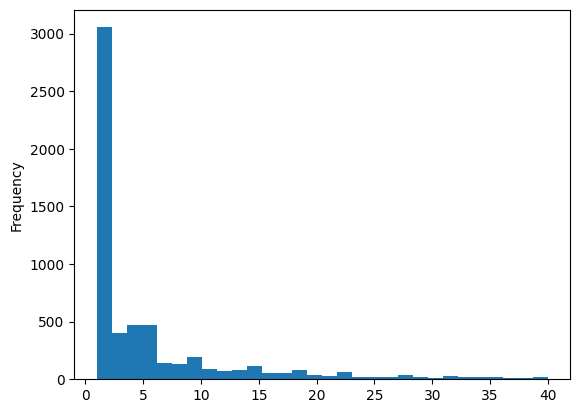

In [ ]:
import matplotlib.pyplot as plt
token_counts_series[token_counts_series.lt(token_counts_series.quantile(0.9))].plot.hist(bins=30)
# plt.xlim(0, token_counts_series.quantile(0.9))

In [ ]:
vocab_size = token_counts_series.gt(10).sum()
vocab_size

1572

In [ ]:
vocab_size = 1572

# KERAS BI GRU

In [ ]:
N_CATEGORIES = pro_df.condition.nunique()
N_CATEGORIES

30

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, concatenate, Embedding
from tensorflow.keras.layers import GRU, Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score


def get_full_bidirectional_model(embed_size_n_feat,
                                 n_categories,
                                 vocab_size,
                                 input_shape,
                                 n_neurons,
                                 dropout_rate=0.2,
                                 opt_alg='nadam'
                                 ):

    # encoder
    inp = Input(shape=(input_shape,))
    x = Embedding(vocab_size, embed_size_n_feat)(inp)
    x = Bidirectional(GRU(n_neurons, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)

    # decoder
    x = Dropout(dropout_rate)(x)
    x = Dense(n_neurons, activation="relu")(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(n_categories, activation="softmax")(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt_alg)

    return model

model = get_full_bidirectional_model(embed_size_n_feat=32,
                                     n_categories=N_CATEGORIES,
                                     vocab_size=vocab_size,
                                     input_shape=200,
                                     n_neurons=10)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 32)           50304     
                                                                 
 bidirectional (Bidirection  (None, 200, 20)           2640      
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 20)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 10)                210   

- un texto de 10 palabras
- tensor (10, embed_size_n_feat)
- tensor (10, n_neurons)
- tensor n_neurons
- tensor n_neurons

In [ ]:
%%capture --no-display
!apt-get install -y graphviz
!pip install pydot graphviz

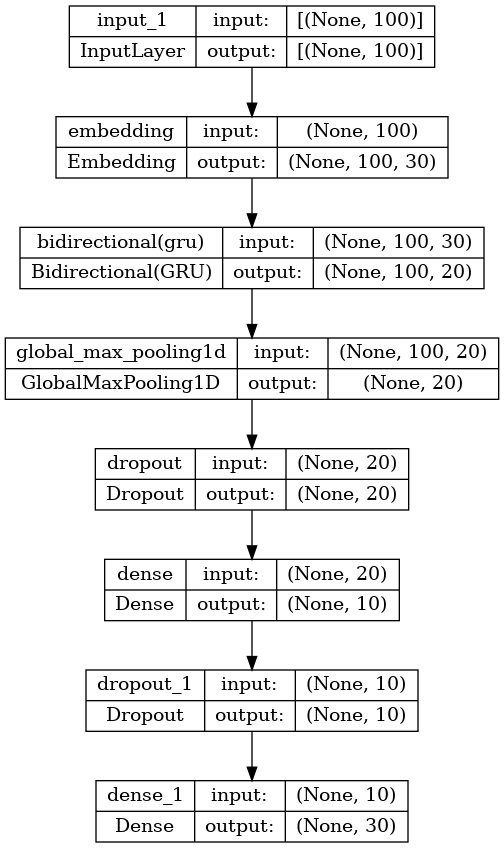

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True,to_file='model.png')

In [ ]:
from tensorflow.keras.preprocessing import text, sequence



tokenizer = text.Tokenizer(num_words=vocab_size + 1, oov_token='#OOV')
tokenizer.fit_on_texts(df_train.review.tolist())

In [ ]:
list_tokenized_train = tokenizer.texts_to_sequences(df_train.review.tolist())
list_tokenized_test = tokenizer.texts_to_sequences(df_test.review.tolist())

In [ ]:
MAX_LEN

200

In [ ]:
X_train = sequence.pad_sequences(list_tokenized_train, padding='pre', maxlen=MAX_LEN)
X_test = sequence.pad_sequences(list_tokenized_test, padding='pre', maxlen=MAX_LEN)

In [ ]:
X_train.shape, X_test.shape

((2792, 200), (698, 200))

In [ ]:
list_tokenized_train[1]

[586, 8, 16, 385, 1220, 2, 84, 1, 981, 3, 8, 202, 1, 19, 130, 516, 87, 47, 14]

In [ ]:
X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
X_train.shape

(2792, 200)

In [ ]:
X_train.max(), vocab_size

(1572, 1572)

Pasamos la variable objetivo a one hot encoding

In [ ]:
pro_df.condition

119705    Chronic Myelogenous Leukemia
206180                       Hirsutism
60455                          Dysuria
154893                  Dental Abscess
102720                          Autism
                      ...             
60966          Dietary Supplementation
44591                      Muscle Pain
111790                     Muscle Pain
190758                     Prostatitis
92720                         Rhinitis
Name: condition, Length: 3490, dtype: object

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_enc = LabelBinarizer()
label_enc.fit(pro_df.condition.values)
label_enc.transform(df_train.condition.values).shape

(2792, 30)

In [ ]:
label_enc.transform(df_train.condition.values)

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_train.shape

(2792, 200)

In [ ]:
model = get_full_bidirectional_model(input_shape=MAX_LEN,
                                     n_categories=N_CATEGORIES,
                                     n_neurons=32,
                                     embed_size_n_feat=32,
                                     vocab_size=vocab_size + 1)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 32)           50336     
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 64)           12672     
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

WEIGHTS_PATH = 'bigru.hdf5'
#introducimos los chekpoints, estos guardan el mejor modelo después de actualizar todas las epochs
checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='val_loss', verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1,
                           restore_best_weights=True)

hist = model.fit(X_train,
                  label_enc.transform(df_train.condition.values),
                  batch_size=2 ** 6,
                  epochs=1000_000,
                  validation_split=0.1,
                  callbacks=[early_stop, checkpoint])

Epoch 1/1000000
40/40 [==============================] - 21s 290ms/step - loss: 3.3994 - val_loss: 3.3939
Epoch 2/1000000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 6s 146ms/step - loss: 3.3829 - val_loss: 3.3694
Epoch 3/1000000
40/40 [==============================] - 6s 151ms/step - loss: 3.3270 - val_loss: 3.2613
Epoch 4/1000000
40/40 [==============================] - 4s 94ms/step - loss: 3.1166 - val_loss: 2.9001
Epoch 5/1000000
40/40 [==============================] - 3s 88ms/step - loss: 2.6452 - val_loss: 2.3029
Epoch 6/1000000
40/40 [==============================] - 3s 80ms/step - loss: 2.1480 - val_loss: 1.8584
Epoch 7/1000000
40/40 [==============================] - 3s 74ms/step - loss: 1.8183 - val_loss: 1.5894
Epoch 8/1000000
40/40 [==============================] - 3s 64ms/step - loss: 1.5777 - val_loss: 1.4056
Epoch 9/1000000
40/40 [==============================] - 2s 50ms/step - loss: 1.3764 - val_loss: 1.2745
Epoch 10/1000000
40/40 [==============================] - 2s 43ms/step - loss: 1.2344 - val_loss: 1.1468
Epoch 11/1000000
40/40 [==============================] - 2s 51ms/step - loss

In [ ]:
model.load_weights(WEIGHTS_PATH)

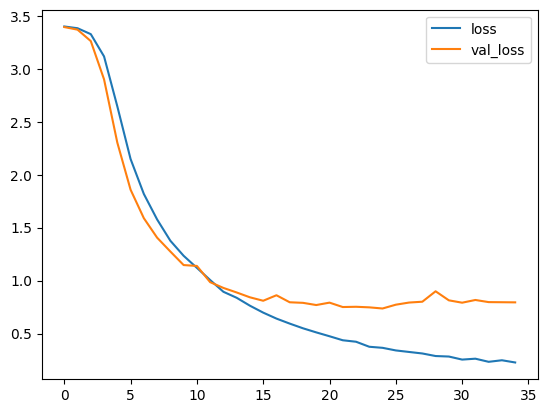

In [ ]:
hist_df = pd.DataFrame(hist.history)
hist_df[['loss', 'val_loss']].plot();

In [ ]:
label_enc.categories_[0]

array(['Allergic Reactions', 'Alopecia', "Alzheimer's Disease",
       'Amenorrhea', 'Angina', 'Anorexia', 'Autism',
       'Benign Essential Trem', 'Binge Eating Disorde',
       'Chronic Fatigue Syndrome', 'Chronic Myelogenous Leukemia',
       'Deep Vein Thrombosis', 'Dental Abscess',
       'Dietary Supplementation', 'Dysuria', 'Heart Failure',
       'Hemorrhoids', 'Hirsutism', 'Muscle Pain', 'Neuralgia',
       'Obstructive Sleep Apnea/Hypopnea Syndrome',
       'Postherpetic Neuralgia', 'Postpartum Depression', 'Premature Lab',
       'Prostatitis', 'Renal Cell Carcinoma', 'Rhinitis',
       'Sinus Symptoms', 'Supraventricular Tachycardia', 'Vertig'],
      dtype=object)

In [ ]:
label_enc.classes_

array(['Allergic Reactions', 'Alopecia', "Alzheimer's Disease",
       'Amenorrhea', 'Angina', 'Anorexia', 'Autism',
       'Benign Essential Trem', 'Binge Eating Disorde',
       'Chronic Fatigue Syndrome', 'Chronic Myelogenous Leukemia',
       'Deep Vein Thrombosis', 'Dental Abscess',
       'Dietary Supplementation', 'Dysuria', 'Heart Failure',
       'Hemorrhoids', 'Hirsutism', 'Muscle Pain', 'Neuralgia',
       'Obstructive Sleep Apnea/Hypopnea Syndrome',
       'Postherpetic Neuralgia', 'Postpartum Depression', 'Premature Lab',
       'Prostatitis', 'Renal Cell Carcinoma', 'Rhinitis',
       'Sinus Symptoms', 'Supraventricular Tachycardia', 'Vertig'],
      dtype='<U41')

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = pd.DataFrame(y_pred_proba, columns=label_enc.classes_).idxmax(axis=1)
y_pred

22/22 [==============================] - 0s 13ms/step


In [ ]:
y_pred.shape

(698,)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(df_test.condition, y_pred))

                                           precision    recall  f1-score   support

                       Allergic Reactions       0.72      0.78      0.75        23
                                 Alopecia       0.68      0.68      0.68        25
                      Alzheimer's Disease       0.92      0.96      0.94        23
                               Amenorrhea       0.92      0.92      0.92        24
                                   Angina       0.91      0.80      0.85        25
                                 Anorexia       0.89      0.73      0.80        22
                                   Autism       0.92      0.96      0.94        24
                    Benign Essential Trem       0.84      0.91      0.87        23
                     Binge Eating Disorde       0.95      0.90      0.92        20
                 Chronic Fatigue Syndrome       0.70      0.83      0.76        23
             Chronic Myelogenous Leukemia       0.95      0.83      0.88        23
   

In [ ]:
roc_auc_score(pd.get_dummies(df_test.condition), y_pred_proba) #0.9699
# 0.97793

0.9754843353664495

In [ ]:
balanced_accuracy_score(df_test.condition, y_pred)

0.8014989020641194

# DAN model

Modelo exclusivamente basado en capas densas apiladas encima de un embebimiento del texto representado por la media del embebimiento sus palabras. Este modelo NO TIENE EN CUENTA ORDEN.

Deep Averaging Networks https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf https://github.com/miyyer/dan

Usamos ragged tensors, que son muy útiles para texto ya que se trunca habitualmente, así no hay que padear en un modelo como el DAN. Más información de este tipo de tensores en https://www.tensorflow.org/guide/ragged_tensor


important hyperparameters:
- batch size (the smaller the better, but also slower)
- adagrad initial learning rate (should be decreased as the batch size is decreased)
- word dropout probability (30% is the default but might be too high for some tasks)
- number of epochs (increase when using random initialization)

Creamos una capa custom https://www.tensorflow.org/tutorials/customization/custom_layers para poder hacer el dropout de la DAN

https://www.weak-learner.com/blog/2019/07/31/deep-averaging-networks/

In [ ]:
y_train_ohe = label_enc.transform(df_train.condition.values[:, np.newaxis])
y_test_ohe = label_enc.transform(df_test.condition.values[:, np.newaxis])

In [ ]:
import tensorflow as tf

ragged_train_tensor = tf.ragged.constant(list_tokenized_train)
ragged_test_tensor = tf.ragged.constant(list_tokenized_test)
ragged_train_tensor.dtype

tf.int32

In [ ]:
ragged_train_tensor.shape, ragged_test_tensor.shape

(TensorShape([2792, None]), TensorShape([698, None]))

In [ ]:
ragged_train_tensor.to_tensor(shape=(None, 10))

<tf.Tensor: shape=(2792, 10), dtype=int32, numpy=
array([[   6,    1,  117, ...,   15,  329,    5],
       [ 586,    8,   16, ...,    1,  981,    3],
       [ 412,   29,  909, ...,    1,  325,  225],
       ...,
       [ 271,   24,  478, ...,   54,   93,   10],
       [1531,  817,  105, ...,    2,   12,  363],
       [   2,   12,  363, ...,    2,  148,  388]], dtype=int32)>

WORD DROPOUT

En cada batch de documentos, cada palabra de cada documento, tiene una probabilidad de no aparecer en le mismo en el entrenamiento.

"en sevilla llueve poco y hace mucho calor"

- "sevilla poco mucho calor"
- "en llueve poco mucho calor"
- "llueve hace mucho"

In [ ]:
import tensorflow as tf


class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self, X, y,
                 batch_size,
                 dropout_rate=0.3,
                 shuffle=True):

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.shuffle = shuffle
        self.n = X.shape[0]

    def on_epoch_end(self):
        if self.shuffle:
            index_to_shuffle = tf.random.shuffle(tf.range(self.n))
            self.X = tf.gather(self.X, index_to_shuffle)
            self.y = tf.gather(self.y, index_to_shuffle)

    # function to sample from  input ragged tensor with integers representing tokens
    @tf.function(reduce_retracing=True)
    def ragged_sample(self, x):
        length = tf.shape(x)[0]
        float_length = tf.cast(length, dtype=tf.float32)
        sample_size = tf.cast(tf.math.ceil((1.0 - self.dropout_rate) * float_length),
                              dtype=tf.int32)
        val = tf.gather(x, tf.random.shuffle(tf.range(length))[:sample_size])
        return val

    def _sample_from_ragged(self, rt):
        val = tf.map_fn(self.ragged_sample, rt)
        return val

    def __getitem__(self, index):

        batch_X = self.X[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
#         print("SHAPE CHECK: ", batch_X.shape, batch_y.shape)
        batch_X = self._sample_from_ragged(batch_X)
#         print("SHAPE CHECK: ", batch_X.shape, batch_y.shape)

        return batch_X, batch_y

    def __len__(self):
        return self.n // self.batch_size

In [ ]:
custom_gen = CustomDataGen(X=ragged_train_tensor, y=y_train_ohe,
                           batch_size=64, shuffle=False)
custom_gen._sample_from_ragged(ragged_train_tensor[:3])

<tf.RaggedTensor [[627, 117, 21, 13, 1, 4, 1484, 5, 12, 1, 3, 25, 307, 7, 67, 5, 123, 167,
  127, 14, 329, 96, 7, 13, 8, 20, 168, 21, 1, 201, 4, 92, 4, 1, 31, 1, 15,
  248, 30, 67, 1219, 1, 1, 16, 17, 462, 444, 393]                         ,
 [87, 14, 2, 8, 1220, 130, 84, 202, 981, 3, 47, 16, 1, 1],
 [46, 1, 155, 52, 1275, 36, 3, 61, 203, 344, 88, 174, 225, 4, 1274, 1, 1, 1,
  28, 56, 331, 5, 53, 1, 232, 4, 190, 577, 174, 303, 77, 1, 4, 15, 640, 5,
  331, 58, 9, 325, 83, 412, 61, 154, 116, 1, 22, 13, 73]                    ]>

In [ ]:
import tensorflow.keras.layers as layers
from tensorflow.python.eager import context


def get_dan_model(embed_size_n_feat,
                  n_categories,
                  vocab_size,
                  n_neurons_list=[32, 32],
                  dropout_rate=0.2,
                  opt_alg='adam'):

    inp = Input(shape=(None, ), ragged=True, dtype='int32')
    x = Embedding(vocab_size, embed_size_n_feat)(inp)
    x = layers.GlobalAveragePooling1D()(x)

    for n_neurons in n_neurons_list:
        x = Dense(n_neurons, activation="relu")(x)

    x = Dense(n_categories, activation="softmax")(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=opt_alg)

    return model


model = get_dan_model(embed_size_n_feat=64,
                      n_categories=N_CATEGORIES,
                      dropout_rate=0.2,
                      n_neurons_list=[32, 32],
                      vocab_size=vocab_size + 1,
                      opt_alg='adam')

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 64)          100672    
                                                                 
 global_average_pooling1d_2  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 30)                990       
                                                           

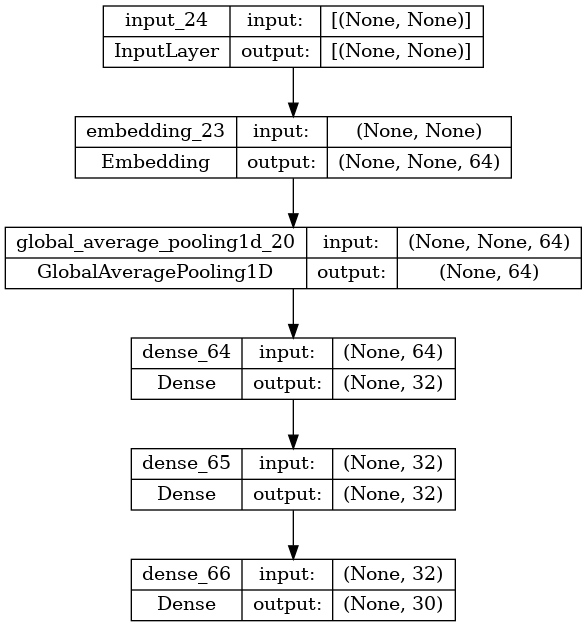

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
custom_gen = CustomDataGen(X=ragged_train_tensor,
                           y=y_train_ohe,
                           dropout_rate=0.3,
                           batch_size=128,
                           shuffle=False)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


es_callback = EarlyStopping('val_loss', patience=20, restore_best_weights=True, verbose=True)

history = model.fit(custom_gen,
                    validation_data=(ragged_test_tensor, y_test_ohe),
                    callbacks=[es_callback],
                    epochs=2000000)

Epoch 1/2000000
21/21 [==============================] - 13s 495ms/step - loss: 3.4002 - val_loss: 3.3975
Epoch 2/2000000
21/21 [==============================] - 7s 319ms/step - loss: 3.3923 - val_loss: 3.3881
Epoch 3/2000000
21/21 [==============================] - 8s 369ms/step - loss: 3.3747 - val_loss: 3.3679
Epoch 4/2000000
21/21 [==============================] - 7s 310ms/step - loss: 3.3381 - val_loss: 3.3253
Epoch 5/2000000
21/21 [==============================] - 7s 295ms/step - loss: 3.2634 - val_loss: 3.2428
Epoch 6/2000000
21/21 [==============================] - 7s 357ms/step - loss: 3.1317 - val_loss: 3.1055
Epoch 7/2000000
21/21 [==============================] - 6s 304ms/step - loss: 2.9308 - val_loss: 2.9195
Epoch 8/2000000
21/21 [==============================] - 6s 299ms/step - loss: 2.6935 - val_loss: 2.7099
Epoch 9/2000000
21/21 [==============================] - 8s 361ms/step - loss: 2.4688 - val_loss: 2.5218
Epoch 10/2000000
21/21 [==============================

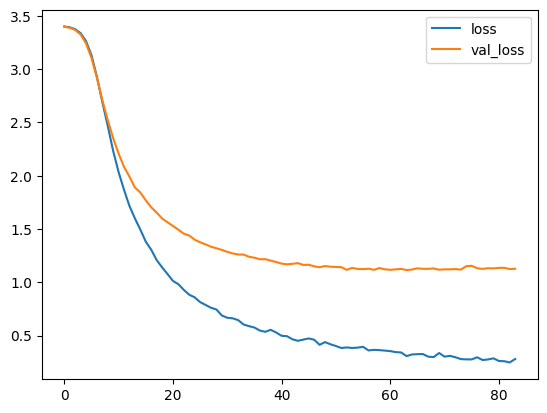

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.plot();

In [ ]:
# y_pred_proba = model.predict_proba(X_test)
# y_pred_proba = pd.DataFrame(y_pred_proba)
y_pred_proba = model.predict(ragged_test_tensor)
y_pred = pd.DataFrame(y_pred_proba, columns=label_enc.classes_).idxmax(axis=1)

22/22 [==============================] - 0s 6ms/step


In [ ]:
y_pred.shape

(698,)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(df_test.condition, y_pred))

                                           precision    recall  f1-score   support

                       Allergic Reactions       0.53      0.78      0.63        23
                                 Alopecia       0.83      0.76      0.79        25
                      Alzheimer's Disease       0.88      0.96      0.92        23
                               Amenorrhea       1.00      0.88      0.93        24
                                   Angina       0.76      0.76      0.76        25
                                 Anorexia       0.83      0.68      0.75        22
                                   Autism       0.92      1.00      0.96        24
                    Benign Essential Trem       1.00      0.83      0.90        23
                     Binge Eating Disorde       1.00      0.90      0.95        20
                 Chronic Fatigue Syndrome       0.68      0.83      0.75        23
             Chronic Myelogenous Leukemia       0.83      0.87      0.85        23
   

In [ ]:
roc_auc_score(pd.get_dummies(df_test.condition), y_pred_proba) #0.9699
# 0.97793

0.9793640984892443

In [ ]:
balanced_accuracy_score(df_test.condition, y_pred)

0.8097055335968378

# Representation

https://keras.io/guides/transfer_learning/

In [ ]:
def extract_encoder_from_keras_model(model, layer_output_number):

    encoder = Model(model.input, model.layers[layer_output_number].output)

    return encoder

In [ ]:
encoder = extract_encoder_from_keras_model(model, -2)
encoder(ragged_train_tensor).shape

TensorShape([2792, 32])

In [ ]:
embedding_arr = encoder(ragged_train_tensor)
embedding_arr.shape

TensorShape([2792, 32])

In [ ]:
type(embedding_arr)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
# !pip install umap-learn

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP(n_components=2, metric='cosine')
umap_embedding = reducer.fit_transform(embedding_arr)

In [ ]:
umap_embedding.shape

(2792, 2)

In [ ]:
cats = pd.Categorical(df_train.condition).codes
cats

array([ 2, 15, 23, ..., 24, 27,  9], dtype=int8)

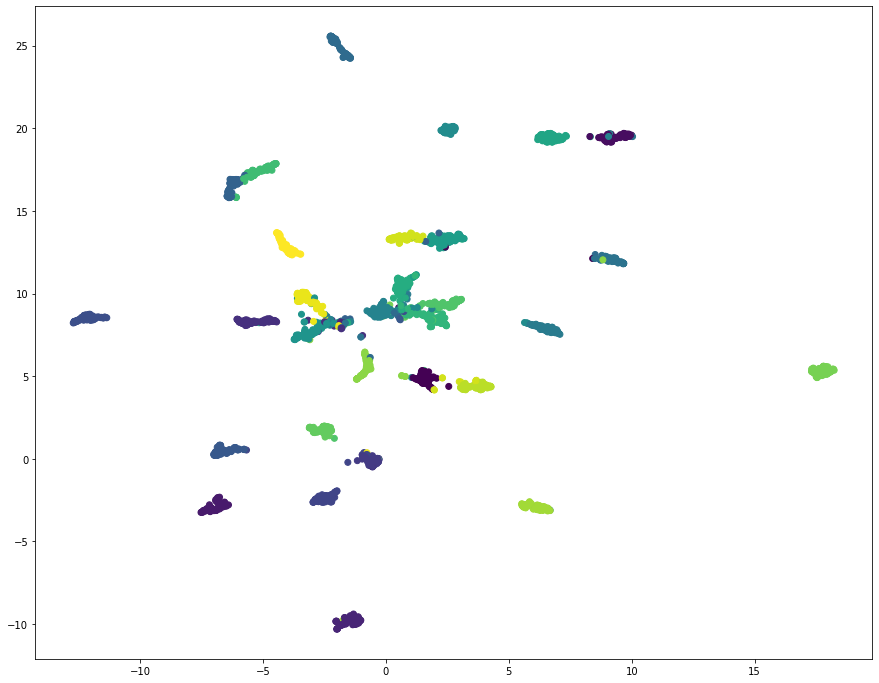

In [ ]:
plt.figure(figsize=(15, 12))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cats);

## DBSCAN over DAN embedding

In [ ]:
from sklearn.cluster import DBSCAN, KMeans

In [ ]:
clustering_model = DBSCAN(eps=0.2,
                min_samples=20,
                metric='cosine',
                n_jobs=-1)

clustering_model = KMeans(n_clusters=30)

In [ ]:
clustering_model.fit(embedding_arr)

KMeans(n_clusters=30)

In [ ]:
clustering_df = pd.DataFrame({'text': df_train.review,
                              'condition': df_train.condition,
                              'label': clustering_model.labels_})

In [ ]:
clustering_df.label.value_counts()

3     319
26    149
9     144
1     131
27    120
22    116
5     104
23     97
11     97
13     92
17     91
18     90
4      89
21     88
20     88
7      87
24     82
8      80
29     76
14     74
10     73
12     72
0      71
2      71
16     70
15     67
6      65
19     63
25     24
28      2
Name: label, dtype: int64

In [ ]:
clustering_df.groupby('label').apply(lambda series: series.sample(np.min([10, series.shape[0]])))

text  \
label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
0     79765                                                      I had two instance of DVT getting to my lungs. Almost killed me. I was on warfarin the first time for 6 months with no side effects. I have been taking xeralto 20 mg for about a month now. I am having insomnia, upset stomach, and occasional muscle cramping in calves and ankles. However, I do not have to go the doctor once a month to have blood tests and I do not have to manage my eating habits so closely. So far I am a fan, albeit a sleepy one.   
      160234  Treated with Coumadin for 3 years.  Stopped Coumadin 2 days ago. Started Xarelto last night 20 mg once a day.  Maybe it is the excitement of being off Coumadin, but today is the first day I feel normal.  No headache, No light headedness, No Fuzzy head, was not tired in the middle of the day.  Coumadin really made me feel different.  I thought it was just getting old.  Also my eyes feel clear now.  First thing I did last night was drink two glasses of cranberry juice. It was great. For lunch ...   
      160102                                                                                                     Hospitalized for 5 days with DVT in both arms.  During my stay I was given lovenox and warfarin.  Upon discharge, I visited my regular MD and was put on Xeralto.  Thirty days later I was admitted to hospital again, but with DVT'S up and down both arms. I would not recommend anyone to take this medication.  I had a horrible experience, not to mention scary experience while being on this medication.   
      79700                                                                                                                                                                                                                                        I was prescribed Xarelto for two months after I got a Deep Vein Thrombsis and pulmonary embolisms and it definitely worked as prescribed.  I did bruise very easily, but that was a small price to pay to completely get rid of my DVT and show no signs of it 3 months later.   
      79751                                                                                                                                                                  I have my second dvt and have been on rivaroxopan for almost five weeks. I'm grateful my leg is less painful and I believe it's working however I have experienced bleeding of the gums unprovoked and also had my first ever nose bleed in the night, never had one in 48 years!! I'm on 20 mg once a day so I think it's making my blood too thin!   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ...   
29    37207   I started what I thought was my weight loss journey at 404 pounds. That was not my biggest but my biggest since my last weight loss adventure. I started with phetermine, ($15 a month). I live in Ohio, so I could only be on it for 3 months as it is a state law that mandates use. I went down to 343. I was put on belviq for 2 months, $80 a month. I gained 10 p

In [ ]:
clustering_df.groupby(['label', 'condition']).count()

text
label condition                    
0     Deep Vein Thrombosis       71
1     Allergic Reactions          2
      Angina                      2
      Deep Vein Thrombosis        2
      Dietary Supplementation     7
...                             ...
27    Vertig                      7
28    Dysuria                     2
29    Anorexia                    1
      Binge Eating Disorde       74
      Dietary Supplementation     1

[124 rows x 1 columns]

In [ ]:
from sklearn.metrics import normalized_mutual_info_score as nmi

In [ ]:
nmi([0, 0, 2, 2], [0, 0, 1, 1])

1.0

In [ ]:
nmi(labels_true=clustering_df.condition, labels_pred=clustering_df.label)

0.806192555032768